# Recommendations Using Hybrid solutions <sup>1</sup>

Lots of examples of systems that try to combine the strengths of the two main approaches.
This can be done in a number of ways:

- Combine the predictions of a content-based system and a collaborative system.
- Incorporate content-based techniques into a collaborative approach.
- Incorporate collaborative techniques into a content-based approach.
- Unifying model.

## Imports

In [1]:
import numpy as np
import pandas as pd
from scipy.special import logsumexp
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report

## Load Data

Only loading a subset of the original data set for proof of concept reasons.

In [2]:
# 80/20 split earlierfrom sklearn.preprocessing import label_binarize
df_train = pd.read_csv('../Data/training_data_subset.csv')
df_test = pd.read_csv('../Data/testing_data_subset.csv')

In [3]:
df_train.head(2)

,category,title,also_buy,brand,rank,also_view,main_cat,price,asin,overall,verified,reviewerID,vote,style,for_testing
0,"['Grocery & Gourmet Food', 'Candy & Chocolate'...","YumEarth Organic Gummy Bears, 10 Count","['B008CC8UXC', 'B00C25LO8S', 'B073RWDCMD', 'B0...",YumEarth,"129,438 in Grocery & Gourmet Food (","['B008CC8UXC', 'B00C25LNWA', 'B008CC8ULY', 'B0...",Grocery,NaN,B008B7JNRA,3.0,True,A35KP4ROS9KWPO,NaN,"{'Size:': ' 10 Count', 'Style:': ' Natural Gum...",False
1,"['Grocery & Gourmet Food', 'Jams, Jellies & Sw...",Bell Plantation Powdered PB2 Bundle: 1 Peanut ...,"['B06W9N8X9H', 'B06X15V3DC', 'B01ENYJX3S', 'B0...",PB2,"1,214 in Grocery & Gourmet Food (",NaN,Grocery,18.49,B00H9H56QA,5.0,True,AVAMZWS7AAI1S,NaN,{'Size:': ' Pack of 2 (1 each flavor)'},False


In [4]:
df_test.head(2)

,category,title,also_buy,brand,rank,also_view,main_cat,price,asin,overall,verified,reviewerID,vote,style,for_testing
0,"['Grocery & Gourmet Food', 'Snack Foods', 'Bar...","Grocery &amp; Gourmet Food"" />","['B01MT0QDPO', 'B00NL17FE4', 'B01NBM9OJN', 'B0...",Nature Valley,"16,921 in Grocery & Gourmet Food (",NaN,Grocery,18.04,B001E6GFR6,5.0,True,A2IUE299OONA73,NaN,NaN,True
1,"['Grocery & Gourmet Food', 'Snack Foods', 'Chi...",Gourmet Basics Smart Fries 4-Flavor Variety Pa...,"['B0763SHX4W', 'B0040FIHS8', 'B00FYR5HS4', 'B0...",Gourmet Basics,"53,167 in Grocery & Gourmet Food (",NaN,Grocery,23.99,B003AZ2ECY,4.0,True,A38NO7J1TK4R1W,NaN,NaN,True


### Evaluate

In [5]:
def compute_rmse(y_pred, y_true):
    """ Compute Root Mean Squared Error. """
    
    return np.sqrt(np.mean(np.power(y_pred - y_true, 2)))

def evaluate_train(estimate_f):
    """ RMSE-based predictive performance evaluation with pandas. """
    
    ids_to_estimate = zip(df_train.reviewerID, df_train.asin)
    estimated = np.array([estimate_f(u,i) for (u,i) in ids_to_estimate])
    real = df_train.overall.values
    return compute_rmse(estimated, real)

## Similarity functions

In [6]:
def euclidean(s1, s2):
    """Take two pd.Series objects and return their euclidean 'similarity'."""
    diff = s1 - s2
    return 1 / (1 + np.sqrt(np.sum(diff ** 2)))

def cosine(s1, s2):
    """Take two pd.Series objects and return their cosine similarity."""
    return np.sum(s1 * s2) / np.sqrt(np.sum(s1 ** 2) * np.sum(s2 ** 2))

def pearson(s1, s2):
    """Take two pd.Series objects and return a pearson correlation."""
    s1_c = s1 - s1.mean()
    s2_c = s2 - s2.mean()
    return np.sum(s1_c * s2_c) / np.sqrt(np.sum(logsumexp(s1_c ** 2)) * np.sum(logsumexp(s2_c ** 2)))

def jaccard(s1, s2):
    dotp = np.sum(s1 * s2)
    return dotp / (np.sum(s1 ** 2) + np.sum(s2 ** 2) - dotp)

In [7]:
class Recommender(object):
    def __init__(self, similarity=pearson):
        self.overall_mean = df_train['overall'].mean()
        self.all_user_profiles = df_train.pivot_table('overall', index='asin', columns='reviewerID')
        self._similarity = similarity
        
    @property
    def similarity(self):
        return self._similarity
    
    @similarity.setter
    def similarity(self, value):
        self._similarity = value
    
    def estimate_product(self, user_id, product_id):
        all_ratings = df_train.loc[df_train.asin == product_id]
        if all_ratings.empty:
            return self.overall_mean
        all_ratings.set_index('reviewerID', inplace=True)
        their_ids = all_ratings.index
        their_ratings = all_ratings.overall
        their_profiles = self.all_user_profiles[their_ids]
        try:
            user_profile = self.all_user_profiles[user_id]
        except KeyError:
            return 4.0 * 0.5 + self.overall_mean * 0.5
        sims = their_profiles.apply(lambda profile: self.similarity(profile, user_profile), axis=0)
        ratings_sims = pd.DataFrame({'sim': sims, 'overall': their_ratings})
        ratings_sims = ratings_sims[ratings_sims.sim > 0]
        if ratings_sims.empty:
            return their_ratings.mean()
        else:
            return np.average(ratings_sims.overall, weights=ratings_sims.sim)

    def estimate_user(self, user_id):
        similar = df_train.loc[df_train.reviewerID == user_id]
        
        if similar.empty:
            return self.overall_mean
        else:
            return similar['overall'].mean()

    def estimate(self, user_id, product_id):
        return 0.9 * self.estimate_user(user_id) + 0.1 * self.estimate_product(user_id, product_id)

In [8]:
functions = [euclidean, cosine, pearson, jaccard]
for estimate in functions:
    rec = Recommender(estimate)
    print(f'RMSE using {estimate.__name__}: {evaluate_train(rec.estimate):.4f}.')

RMSE using euclidean: 0.2027.
RMSE using cosine: 0.2076.
RMSE using pearson: 0.2100.
RMSE using jaccard: 0.2036.


## Evaluate and predict on test data

Only using the most accurate similarity function, euclidean, found earlier.

In [9]:
def evaluate_test(estimate_f):
    """ RMSE-based predictive performance evaluation with pandas. """
    
    ids_to_estimate = zip(df_test.reviewerID, df_test.asin)
    estimated = np.array([estimate_f(u,i) for (u,i) in ids_to_estimate])
    real = df_test.overall.values
    return compute_rmse(estimated, real)

In [10]:
reco = Recommender(euclidean)
print('RMSE for Euclidean: %s' % evaluate_test(reco.estimate))

RMSE for Euclidean: 1.1413154367862572


The recommendation for the test data is much less accurate than the estimates on the training data.
However, this is the best results so far and is better than the initial baseline found in v0.

## Other Performance Evaluation Systems

In [11]:
rec = Recommender(euclidean)
ids_to_estimate = zip(df_test.reviewerID, df_test.asin)
y_pred = np.array([rec.estimate(u,i) for (u,i) in ids_to_estimate])
y_test = df_test.overall.values

In [12]:
# Make both np arrays int for comparison
y_pred = np.rint(y_pred)

### Confusion Matrix

<AxesSubplot:>

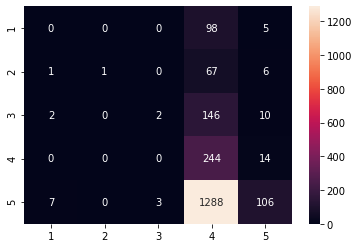

In [13]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])

### Accuracy, Precision, Recall, and F1-Score

In [14]:
print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
print('Classification report:')
print(classification_report(y_test, y_pred))

Accuracy score: 0.1765
Classification report:
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       103
         2.0       1.00      0.01      0.03        75
         3.0       0.40      0.01      0.02       160
         4.0       0.13      0.95      0.23       258
         5.0       0.75      0.08      0.14      1404

    accuracy                           0.18      2000
   macro avg       0.46      0.21      0.08      2000
weighted avg       0.61      0.18      0.13      2000



These evaluation metrics are all significantly lower than desired.

### ROC Curve <sup>2</sup>

In [15]:
y_test_bi = label_binarize(y_test, classes=[1,2,3,4,5])
y_pred_bi = label_binarize(y_pred, classes=[1,2,3,4,5])
n_classes = 5

In [16]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bi[:, i], y_pred_bi[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

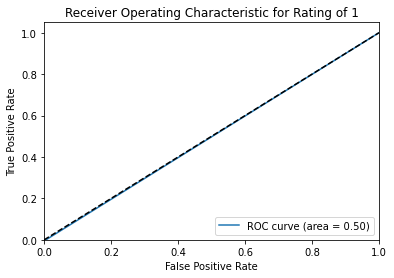

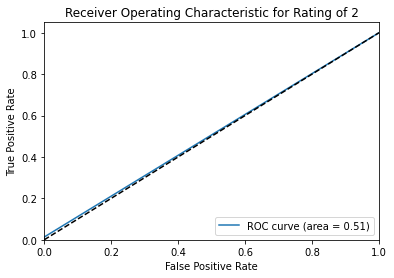

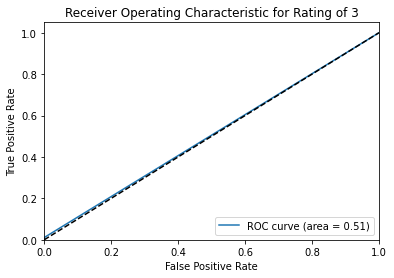

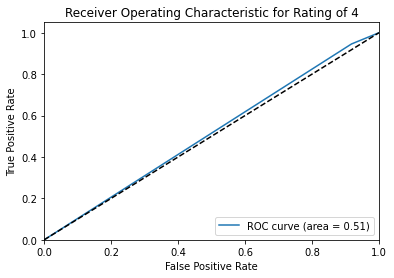

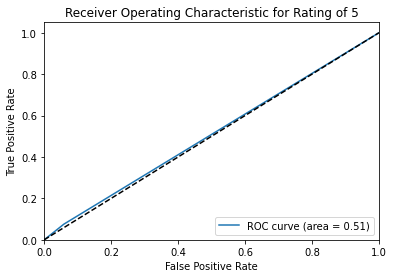

In [17]:
# Plot ROC curve
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for Rating of {i + 1}')
    plt.legend(loc="lower right")
    plt.show()

This shows that the results from the predicted model are no better than random chance.
However, this does complete the desired proof of concepts for this educational capstone project.
In the project's final presentation, there will be several recommendations about how to further improve this projects performance and also possible enhancements for future projects.

## Summary
- Evaluated estimated recommendations using several hybrid methods.
- In all cases, the estimates were significantly better than all previous notebook versions.
- The best performing was euclidean with a RMSE of 0.2027.
- The worse performing was pearson with a RMSE of 0.21.

## References
1) Unata 2015 [Hands-on with PyData: How to Build a Minimal Recommendation Engine](https://www.youtube.com/watch?v=F6gWjOc1FUs).  
2) StackOverflow 2017 [ROC for multiclass classification](https://stackoverflow.com/questions/45332410/roc-for-multiclass-classification).  